# The many colors of the TNG100 simulation

This notebook performs the analysis of the TNG-SKIRT broadband fluxes, as presented in Gebek et al. 2024. With this notebook and the SKIRT simulation results for IllustrisTNG all figures from Gebek et al. 2024 can be reproduced. The notebook does not contain all tests we performed for our study (some of them are mentioned in Gebek et al. 2024), so please reach out to andrea.gebek@ugent.be if you would like to have access to those as well.

Created by Andrea Gebek on 2.3.2024.

## Requirements

Software: \
python 3.11.5 \
\
Packages: \
numpy 1.24.3 \
h5py 3.9.0 \
astropy 5.1 \
scipy 1.11.1 \
matplotlib 3.7.2 \
ndtest (https://github.com/syrte/ndtest)\
\
The ndtest package is required to perform 2D Kolmogorow-Smirnov tests. However, it is possible to omit the calculation of these test statistics and still generate the figures in Gebek et al. 2024. If you wish to avoid installing ndtest, adjust the cell below.

In [19]:
import_ndtest = True

As the SKIRT data for the IllustrisTNG galaxies is quite bulky (approximately 2 GB), these need to be downloaded from the [IllustrisTNG](www.tng-project.org) website. The SKIRT files contain the redshift 0 and 0.1 snapshots in one hdf5 file, i.e. only one file for TNG100-1 and one file for TNG50-1 is needed. For TNG100-1, this file is located at http://www.tng-project.org/api/TNG100-1/files/skirt_bands_seds.hdf5. For TNG50-1, this file is located at https://www.tng-project.org/api/TNG50-1/files/skirt_bands_seds.hdf5. Note that you need an api-key to access these IllustrisTNG data products. Adjust the paths below according to where you store the hdf5 files.

In [20]:
SKIRTfilename = {'TNG100_1': '../tng_subhaloCat/TNG100_1/skirt_TNG100_1.hdf5', 'TNG50_1': '../tng_subhaloCat/TNG50_1/skirt_TNG50_1.hdf5'}
# Filenames for the SKIRT TNG100-1/TNG50-1 fluxes relative to this analysis notebook

After downloading the SKIRT files (and optionally installing the ndtest package), the entire notebook can be run (on a decent laptop typically in a few minutes).

## Load packages and set constants

Import the python packages.

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
import h5py
from scipy import interpolate, stats
if import_ndtest:
    import ndtest # Needed for 2D-KS tests.

Plotting aesthetics.

In [22]:
plotFactor = 0.6
matplotlib.rcParams['axes.linewidth'] = 1.5 * plotFactor
matplotlib.rcParams['xtick.major.size'] = 6 * plotFactor
matplotlib.rcParams['xtick.minor.size'] = 4 * plotFactor
matplotlib.rcParams['xtick.major.width'] = 1.5 * plotFactor
matplotlib.rcParams['xtick.minor.width'] = 1. * plotFactor
matplotlib.rcParams['ytick.major.size'] = 6 * plotFactor
matplotlib.rcParams['ytick.minor.size'] = 4 * plotFactor
matplotlib.rcParams['ytick.major.width'] = 1.5 * plotFactor
matplotlib.rcParams['ytick.minor.width'] = 1. * plotFactor
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams.update({'font.size': 22 * plotFactor})

Set constants.

In [23]:
h_Hubble = 0.6774
cosmo = FlatLambdaCDM(h_Hubble * 100., 0.3089, Tcmb0 = 2.7255) # IllustrisTNG cosmology

TNG_boxsize = {'TNG100_1': 75e6 / h_Hubble, 'TNG50_1': 35e6 / h_Hubble} # TNG box sizes in pc
TNG_redshifts = {'99': 2.22044604925031e-16, '91': 0.0994018026302219} # Redshifts of the TNG snapshots

c = 2.998e8 # Speed of light in m/s
LsunToW = 3.83e26 # Solar luminosity to Watt
pcToM = 3.085677581e16 # Parsec to meter

# All available bands in SKIRT, with their respective pivot wavelengths in micron

pivotWavelengthsSKIRT = {'GALEX_FUV': 0.15351, 'GALEX_NUV': 0.23008, 'SDSS_u': 0.35565, 'SDSS_g': 0.47024, 'SDSS_r': 0.61755, 'SDSS_i': 0.74899, 'SDSS_z': 0.89467,
 'TwoMASS_J': 1.2393, 'TwoMASS_H': 1.6494, 'TwoMASS_Ks': 2.1638, 'UKIDSS_Z': 0.88263, 'UKIDSS_Y': 1.0314, 'UKIDSS_J': 1.2501,
 'UKIDSS_H': 1.6354, 'UKIDSS_K': 2.2058, 'Johnson_U': 0.35236, 'Johnson_B': 0.44146, 'Johnson_V': 0.55223, 'Johnson_R': 0.68967,
 'Johnson_I': 0.87374, 'Johnson_J': 1.2429, 'Johnson_M': 5.0114, 'WISE_W1': 3.3897, 'WISE_W2': 4.6406, 'WISE_W3': 12.568,
 'WISE_W4': 22.314, 'IRAS_12': 11.4, 'IRAS_25': 23.605, 'IRAS_60': 60.344, 'IRAS_100': 101.05, 'IRAC_I1': 3.5508, 'IRAC_I2': 4.496,
 'IRAC_I3': 5.7245, 'IRAC_I4': 7.8842, 'MIPS_24': 23.759, 'MIPS_70': 71.987, 'MIPS_160': 156.43, 'PACS_70': 70.77, 'PACS_100': 100.8,
 'PACS_160': 161.89, 'SPIRE_250': 252.55, 'SPIRE_350': 354.27, 'SPIRE_500': 515.36, 'SCUBA2_450': 449.3, 'SCUBA2_850': 853.81,
 'ALMA_10': 349.89, 'ALMA_9': 456.2, 'ALMA_8': 689.59, 'ALMA_7': 937.98, 'ALMA_6': 1244.4, 'PLANCK_857': 352.42, 'PLANCK_545': 545.55, 'PLANCK_353': 839.3}

SKIRTbands = pivotWavelengthsSKIRT.keys()

# All available bands in GAMA, with their respective pivot wavelengths in micron

pivotWavelengthsGAMA = {'GALEX_FUV': 0.15351, 'GALEX_NUV': 0.23008, 'SDSS_u': 0.35565, 'SDSS_g': 0.47024, 'SDSS_r': 0.61755, 'SDSS_i': 0.74899, 'SDSS_z': 0.89467,
'VISTA_Z': 0.87932, 'VISTA_Y': 1.021041, 'VISTA_J': 1.2525, 'VISTA_H': 1.643245, 'VISTA_K': 2.1522, 'WISE_W1': 3.3897, 'WISE_W2': 4.6406, 'WISE_W3': 12.568, 'WISE_W4': 22.314,
'PACS_100': 100.8, 'PACS_160': 161.89, 'SPIRE_250': 252.55, 'SPIRE_350': 354.27, 'SPIRE_500': 515.36}

GAMAbands = pivotWavelengthsGAMA.keys()

def Mab_to_L(M, lam):  # in mag, microns
    # Convert absolute magnitude to luminosity (in solar luminosities)
    nu = c / (lam * 1e-6)
    return nu * (4. * np.pi * (10. * pcToM)**2) * 3631e-26 * 10**(-0.4 * M.astype('float64')) / LsunToW


## Read in the simulation data

Read in the SKIRT files for TNG100-1 & TNG50-1 (for snapshots 99 & 91).

In [24]:
IDs_SKIRT = {}
Fluxes_SKIRT = {}
Mags_SKIRT = {}
SEDs_SKIRT = {}

for sim in ['TNG100_1', 'TNG50_1']:

    SKIRTfile = h5py.File(SKIRTfilename[sim], 'r')
    SKIRTbands = SKIRTfile.attrs['bands'] # The same for all datasets

    for snapshot in ['99', '91']:
        
        IDs_SKIRT_unordered = SKIRTfile['Snapshot_' + snapshot + '/SubhaloID'][:]
        orderSKIRT_IDs = np.argsort(IDs_SKIRT_unordered) # In some SKIRT files, the order is not in increasing subhalo ID. Change this to have the galaxies ordered.

        IDs_SKIRT[sim + '_' + snapshot] = SKIRTfile['Snapshot_' + snapshot + '/SubhaloID'][:][orderSKIRT_IDs]
        Fluxes_SKIRT[sim + '_' + snapshot] = SKIRTfile['Snapshot_' + snapshot + '/Fluxes'][:][orderSKIRT_IDs]
        Mags_SKIRT[sim + '_' + snapshot] = SKIRTfile['Snapshot_' + snapshot + '/Mags'][:][orderSKIRT_IDs]
        SEDs_SKIRT[sim + '_' + snapshot] = SKIRTfile['Snapshot_' + snapshot + '/SEDs'][:][orderSKIRT_IDs]

        SEDwavelengths_SKIRT = SKIRTfile['Snapshot_' + snapshot + '/SEDs_wave'][:] # The same for all simulationss/snapshots

        print(len(IDs_SKIRT_unordered), 'galaxies in ' + sim + ' for snapshot ' + snapshot + ' with calculated SKIRT fluxes.')

    SKIRTfile.close()

30712 galaxies in TNG100_1 for snapshot 99 with calculated SKIRT fluxes.
30364 galaxies in TNG100_1 for snapshot 91 with calculated SKIRT fluxes.
7375 galaxies in TNG50_1 for snapshot 99 with calculated SKIRT fluxes.
7302 galaxies in TNG50_1 for snapshot 91 with calculated SKIRT fluxes.


Read in the TNG subhalo data for TNG100-1 & TNG50-1 (snapshots 99 & 91). These are available in prepared .txt files in this github repository, and contain the subhalo IDs, stellar masses (in two stellar half-mass radii), stellar half-mass radii, and group numbers.

In [25]:
MstarInRad_TNG = {}
Rstar_TNG = {}
GrNr_TNG = {}

for sim in ['TNG100_1', 'TNG50_1']:

    for snapshot in ['99', '91']:

        subhaloCat_filename = 'simulationData/SubhaloCat_' + sim + '_' + snapshot + '.txt'

        subhaloCat = np.loadtxt(subhaloCat_filename)

        MstarInRad_TNG[sim + '_' + snapshot] = subhaloCat[:, 1] # In solar masses
        Rstar_TNG[sim + '_' + snapshot] = subhaloCat[:, 2] # In kpc
        GrNr_TNG[sim + '_' + snapshot] = subhaloCat[:, 3] # Group number


The SED breakdown into the various components for each galaxy is not part of the public data release. However, this repository contains a txt file with the values for the entire galaxy population, which is sufficient to reproduce figure 1 from the paper.

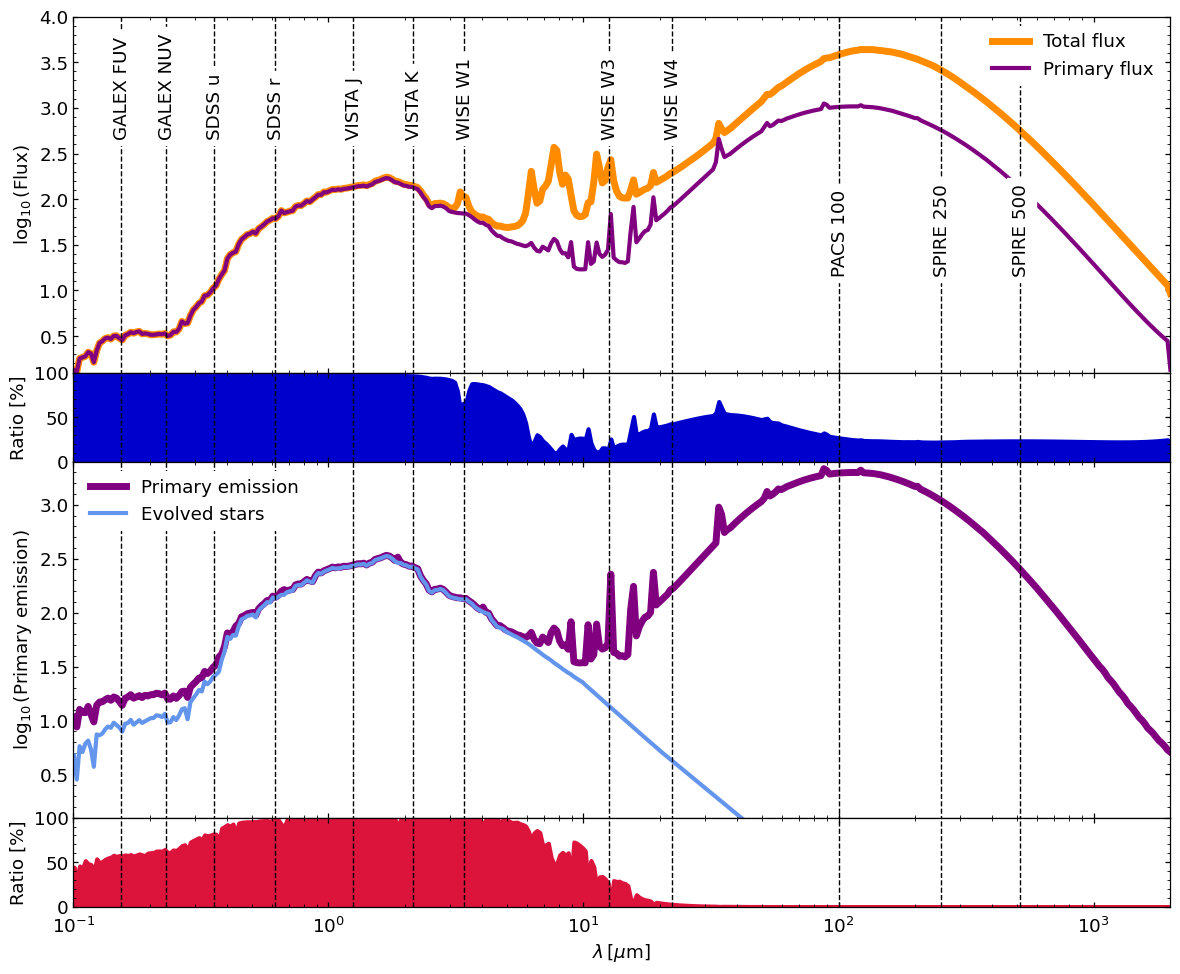

In [26]:
wavelength, SED_total, SED_primary, SED_primaryEmission, SED_evolvedStars = np.loadtxt('simulationData/SEDbreakdown.txt', unpack = True)

# Arbitrary normalizations to make the plot look nice
normalization_0 = 80.
normalization_1 = 2e24

fig, axes = plt.subplots(figsize = (12., 10.), nrows = 4, ncols = 1, height_ratios = [1., 0.25, 1., 0.25])

axes[0].plot(wavelength, np.log10(SED_total / normalization_0), color = 'darkorange', linewidth = 5., label = 'Total flux')
axes[0].plot(wavelength, np.log10(SED_primary / normalization_0), color = 'purple', linewidth = 3., label = 'Primary flux')
axes[1].fill_between(wavelength, SED_primary / SED_total * 100., color = 'mediumblue', linewidth = 3.)


lg0 = axes[0].legend(loc = 'upper right')
lg0.get_frame().set_linewidth(0.0)
lg0.get_frame().set_alpha(None)


axes[2].plot(wavelength, np.log10(SED_primaryEmission / normalization_1), color = 'purple', linewidth = 5., label = 'Primary emission')
with np.errstate(divide = 'ignore'):
    axes[2].plot(wavelength, np.log10(SED_evolvedStars / normalization_1), color = 'cornflowerblue', linewidth = 3., label = 'Evolved stars')
axes[3].fill_between(wavelength, SED_evolvedStars / SED_primaryEmission * 100., color = 'crimson', linewidth = 3.)

lg1 = axes[2].legend(loc = 'upper left')
lg1.get_frame().set_linewidth(0.0)
lg1.get_frame().set_alpha(None)

pivotWavelengths_figure1 = {'GALEX_FUV': 0.15351, 'GALEX_NUV': 0.23008, 'SDSS_u': 0.35565, 'SDSS_r': 0.61755,
'VISTA_J': 1.2525, 'VISTA_K': 2.1522, 'WISE_W1': 3.3897, 'WISE_W3': 12.568, 'WISE_W4': 22.314,
'PACS_100': 100.8, 'SPIRE_250': 252.55, 'SPIRE_500': 515.36}

labels = {'GALEX_FUV': 'GALEX FUV', 'GALEX_NUV': 'GALEX NUV', 'SDSS_u': 'SDSS u', 'SDSS_r': 'SDSS r',
          'VISTA_J': 'VISTA J', 'VISTA_K': 'VISTA K', 'WISE_W1': 'WISE W1', 'WISE_W3': 'WISE W3',
          'WISE_W4': 'WISE W4', 'PACS_100': 'PACS 100', 'SPIRE_250': 'SPIRE 250', 'SPIRE_500': 'SPIRE 500'}

axes[0].vlines(pivotWavelengths_figure1.values(), ymin = 0., ymax = 4., color = 'black', linewidth = 1., linestyle = '--')
axes[1].vlines(pivotWavelengths_figure1.values(), ymin = 0., ymax = 100., color = 'black', linewidth = 1., linestyle = '--')
axes[2].vlines(pivotWavelengths_figure1.values(), ymin = 0., ymax = 3.4, color = 'black', linewidth = 1., linestyle = '--')
axes[3].vlines(pivotWavelengths_figure1.values(), ymin = 0., ymax = 100., color = 'black', linewidth = 1., linestyle = '--')

for key in pivotWavelengths_figure1.keys():
    if pivotWavelengths_figure1[key] > 100.:
        yText = 1.2
    else:
        yText = 2.7

    axes[0].text(x = pivotWavelengths_figure1[key] * 0.93, y = yText, s = labels[key], rotation = 'vertical', backgroundcolor = 'white')

axes[3].set_xlabel('$\lambda\,[\mu\mathrm{m}]$')
axes[0].set_ylabel(r'$\log_{10}(\mathrm{Flux})$')
axes[1].set_ylabel('Ratio [%]')
axes[2].set_ylabel(r'$\log_{10}(\mathrm{Primary\ emission})$')
axes[3].set_ylabel('Ratio [%]')

axes[0].set_ylim(0.1, 4.)
axes[1].set_ylim(0., 100.)
axes[2].set_ylim(0.1, 3.4)
axes[3].set_ylim(0., 100.)

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlim(0.1, 2000.)

    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.minorticks_on()

axes[3].tick_params(axis = 'x', which = 'both', pad = 7.)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[2].set_xticklabels([])


plt.tight_layout()
plt.subplots_adjust(hspace = 0)
plt.show()

## Read in the observational GAMA data

Note that the GAMAcatalogue.fits file is a custom-made catalogue containing the information from multiple GAMA tables for a subset of GAMA galaxies.

In [27]:
F_GAMA = {}
Ferror_GAMA = {}

with fits.open('observationData/GAMAcatalogue.fits') as f:

    columns = f[1].columns

    data = f[1].data

    z_GAMA = data['redshift'] # Redshift
    Mstar_GAMA = 10**data['logmstar'] # Luminous stellar mass, i.e. excluding the mass of stellar remnants. In solar masses

    aperture_GAMA = np.sqrt(data['aperture_major'] * data['aperture_minor']) # Circularized radius of elliptical aperture, in kpc

    for band in pivotWavelengthsGAMA.keys():
        F_GAMA[band] = data[band + '_flux'] # In Jy
        Ferror_GAMA[band] = data[band + '_fluxErr'] # In Jy

    print(len(z_GAMA), 'galaxies in the GAMA sample.')


17932 galaxies in the GAMA sample.


## Luminosity functions

Figure 2 consists of a comparison of various low-redshift luminosity functions to TNG100/TNG50. First, compute the TNG luminosity functions.

In [28]:
# Compute the LFs for TNG100-1 and TNG50-1 (combining snapshots 99 & 91)

LFcount_sim_dict = {'TNG50_1': {}, 'TNG100_1': {}}

dlogL = 0.15 # Spacing in dex for the luminosity bins (to compute LF for TNG)
MstarPercentile = 5. # Select the percentile level to compute the lowest stellar-mass bin
LPercentile = 90. # Select the percentile level to only include luminosity bins above this level (calculated in the lowest stellar-mass bin)

Lbins = np.arange(6.4, 12.5, dlogL) # Bins for the LF (in log10(solar luminosity))
LbinMidpoints = (Lbins[:-1] + Lbins[1:]) / 2.


for sim in LFcount_sim_dict.keys():

    Mstar_TNG = np.concatenate((MstarInRad_TNG[sim + '_99'], MstarInRad_TNG[sim + '_91']))

    Mstar_lowmassThreshold = np.percentile(Mstar_TNG, MstarPercentile)
    SEL_lowmass = (Mstar_TNG <= Mstar_lowmassThreshold)

    for idx, band in enumerate(np.append(SKIRTbands, 'TIR')):
        
        if band == 'TIR': # Compute the total infrared as sum of five infrared fluxes
            M_24 = np.concatenate((Mags_SKIRT[sim + '_99'][:, (SKIRTbands == 'MIPS_24'), 3, 2], Mags_SKIRT[sim + '_91'][:, (SKIRTbands == 'MIPS_24'), 3, 2])).flatten()
            M_70 = np.concatenate((Mags_SKIRT[sim + '_99'][:, (SKIRTbands == 'PACS_70'), 3, 2], Mags_SKIRT[sim + '_91'][:, (SKIRTbands == 'PACS_70'), 3, 2])).flatten()
            M_100 = np.concatenate((Mags_SKIRT[sim + '_99'][:, (SKIRTbands == 'PACS_100'), 3, 2], Mags_SKIRT[sim + '_91'][:, (SKIRTbands == 'PACS_100'), 3, 2])).flatten()
            M_160 = np.concatenate((Mags_SKIRT[sim + '_99'][:, (SKIRTbands == 'PACS_160'), 3, 2], Mags_SKIRT[sim + '_91'][:, (SKIRTbands == 'PACS_160'), 3, 2])).flatten()
            M_250 = np.concatenate((Mags_SKIRT[sim + '_99'][:, (SKIRTbands == 'SPIRE_250'), 3, 2], Mags_SKIRT[sim + '_91'][:, (SKIRTbands == 'SPIRE_250'), 3, 2])).flatten()

            L = 2.023 * Mab_to_L(M_24, pivotWavelengthsSKIRT['MIPS_24']) + 0.523 * Mab_to_L(M_70, pivotWavelengthsSKIRT['PACS_70']) + 0.39 * Mab_to_L(M_100, pivotWavelengthsSKIRT['PACS_100']) + \
                0.577 * Mab_to_L(M_160, pivotWavelengthsSKIRT['PACS_160']) + 0.721 * Mab_to_L(M_250, pivotWavelengthsSKIRT['SPIRE_250']) # Total infrared

        else:
            SELband = (SKIRTbands == band) # Select the proper band
            pivotWavelength = pivotWavelengthsSKIRT[band]
            M = np.concatenate((Mags_SKIRT[sim + '_99'][:, SELband, 3, 2], Mags_SKIRT[sim + '_91'][:, SELband, 3, 2])).flatten()

            L = Mab_to_L(M, pivotWavelength)

        L_lim = np.percentile(L[SEL_lowmass], LPercentile) # Compute the threshold luminosity

        SEL_notLowL = (LbinMidpoints >= np.log10(L_lim)) # Discard bins below the threshold luminosity
            

        with np.errstate(divide = 'ignore'):
            NgalInLbin = np.histogram(np.log10(L), Lbins)[0]

        LFcount_sim_dict[sim][band] = NgalInLbin[SEL_notLowL] # For each band, compute the number of galaxies in the luminosity bin

Define the bands to plot (and various other plotting settings).

In [29]:
# Various plot settings

bandsToPlot = ['GALEX_FUV', 'GALEX_NUV', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z', 'UKIDSS_Y', 'UKIDSS_J', 'UKIDSS_H', 'UKIDSS_K', 'SPIRE_250', 'SPIRE_350', 'SPIRE_500', 'TIR']
bandLabels = ['GALEX FUV', 'GALEX NUV', 'SDSS u', 'SDSS g', 'SDSS r', 'SDSS i', 'SDSS z', 'UKIDSS Y', 'UKIDSS J', 'UKIDSS H', 'UKIDSS K', 'SPIRE 250', 'SPIRE 350', 'SPIRE 500', 'TIR']
colorDict = {'Budavari05': 'gold', 'Wyder05': 'peru', 'Driver12': 'grey', 'Hill10': 'fuchsia', 'Loveday12': 'chartreuse', 'Dunne11': 'lime', 'Negrello14': 'coral', 'Marchetti16': 'darkorchid'}
markerDict = {'Budavari05': 'o', 'Wyder05': '<', 'Driver12': 's', 'Hill10': '>', 'Loveday12': 'P', 'Dunne11': 'v', 'Negrello14': '^', 'Marchetti16': 'X'}
markerSizeDict = {'Budavari05': 4., 'Wyder05': 6., 'Driver12': 6., 'Hill10': 6., 'Loveday12': 45., 'Dunne11': 6., 'Negrello14': 6., 'Marchetti16': 6.}
colorSimDict = {'TNG100_1': 'crimson', 'TNG50_1': 'purple'}
textDict = {'TNG100_1': r'$N_\mathrm{TNG100}=$', 'TNG50_1': r'$N_\mathrm{TNG50}=$'}



Make the LF plot (figure 2).

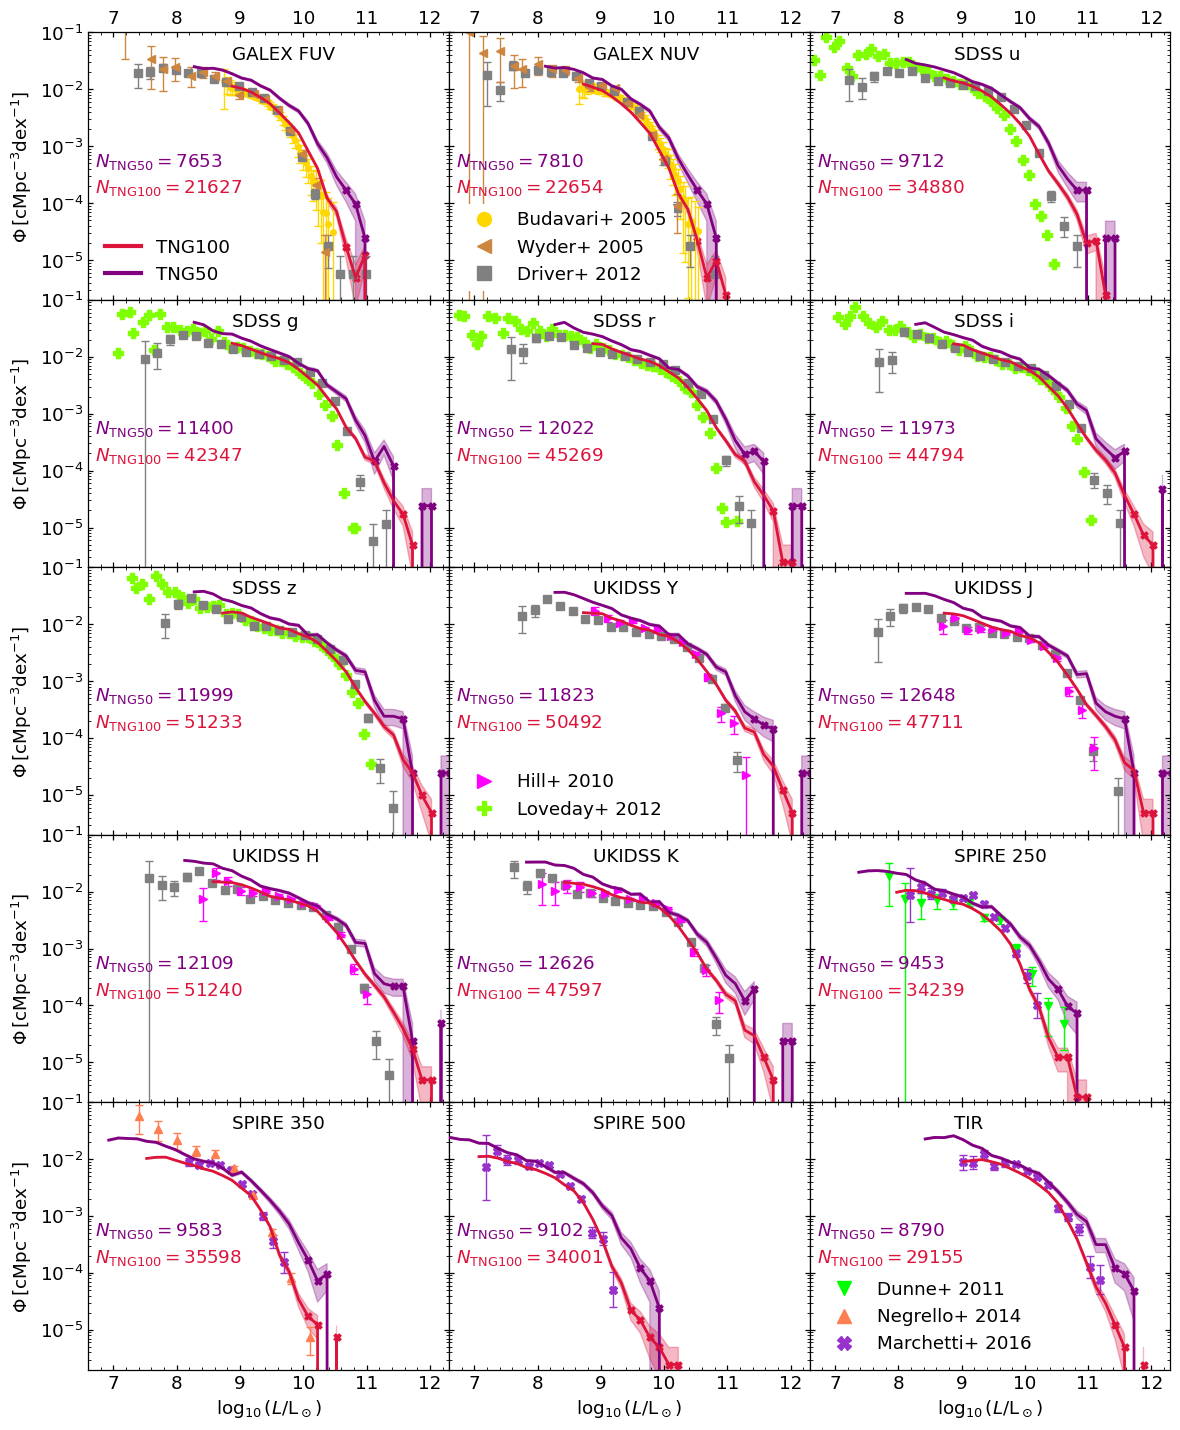

In [30]:
LFfile = h5py.File('observationData/LFcatalogue.hdf5', 'r') # LF data compilation


# Make the plot

fig, axes = plt.subplots(figsize = (12., 14.5), nrows = 5, ncols = 3)

for idx_i in range(5):
    for idx_j in range(3):
        idx = 3 * idx_i + idx_j

        # Plot the simulation data


        for idxSim, sim in enumerate(LFcount_sim_dict.keys()):
            LF_sim = LFcount_sim_dict[sim][bandsToPlot[idx]] / (dlogL * 2. * (TNG_boxsize[sim] * 1e-6)**3)
            LF_poissonError = np.sqrt(LFcount_sim_dict[sim][bandsToPlot[idx]]) / (dlogL * 2. * (TNG_boxsize[sim] * 1e-6)**3)

            Ngal = np.sum(LFcount_sim_dict[sim][bandsToPlot[idx]])

            SEL_fewgals = (LFcount_sim_dict[sim][bandsToPlot[idx]] < 10)

            idxStartLF = len(LbinMidpoints) - len(LF_sim) # Get the luminosity bin index from which we consider the LF to be reliable

            axes[idx_i, idx_j].plot(LbinMidpoints[idxStartLF:], LF_sim, color = colorSimDict[sim], linewidth = 2., zorder = 10)
            axes[idx_i, idx_j].fill_between(LbinMidpoints[idxStartLF:], LF_sim - LF_poissonError, LF_sim + LF_poissonError, color = colorSimDict[sim], alpha = 0.3)

            axes[idx_i, idx_j].scatter(LbinMidpoints[idxStartLF:][SEL_fewgals], LF_sim[SEL_fewgals], color = colorSimDict[sim], marker = 'X', s = 25.)

            axes[idx_i, idx_j].text(x = 0.02, y = 0.5 - 0.1 * idxSim, s = textDict[sim] + str(Ngal), transform = axes[idx_i, idx_j].transAxes, color = colorSimDict[sim])

        # Plot the observational data for this band

        for keyDataset in LFfile[bandsToPlot[idx]].keys():
            LFdata = LFfile[bandsToPlot[idx]][keyDataset]
            
            L_data = LFdata[:, 0]
            LF_data = LFdata[:, 1]


            if keyDataset == 'Loveday12': # No errorbars for this dataset
                axes[idx_i, idx_j].scatter(np.log10(L_data), LF_data, color = colorDict[keyDataset], s = markerSizeDict[keyDataset], marker = markerDict[keyDataset])
            else:
                axes[idx_i, idx_j].errorbar(np.log10(L_data), LF_data, yerr = (LFdata[:, 3], LFdata[:, 2]), color = colorDict[keyDataset], ms = markerSizeDict[keyDataset], marker = markerDict[keyDataset],
                                            linestyle = 'None', capsize = 3., elinewidth = 1., capthick = 1.)

# Add the legends manually

lg_TNG100 = matplotlib.lines.Line2D([], [], color = colorSimDict['TNG100_1'], linewidth = 3., label = 'TNG100')
lg_TNG50 = matplotlib.lines.Line2D([], [], color = colorSimDict['TNG50_1'], linewidth = 3., label = 'TNG50')

lg_Budavari05 = matplotlib.lines.Line2D([], [], color = colorDict['Budavari05'], marker = markerDict['Budavari05'], linestyle = 'None', markersize = 10., label = 'Budavari+ 2005')
lg_Wyder05 = matplotlib.lines.Line2D([], [], color = colorDict['Wyder05'], marker = markerDict['Wyder05'], linestyle = 'None', markersize = 10., label = 'Wyder+ 2005')
lg_Driver12 = matplotlib.lines.Line2D([], [], color = colorDict['Driver12'], marker = markerDict['Driver12'], linestyle = 'None', markersize = 10., label = 'Driver+ 2012')

lg_Hill10 = matplotlib.lines.Line2D([], [], color = colorDict['Hill10'], marker = markerDict['Hill10'], linestyle = 'None', markersize = 10., label = 'Hill+ 2010')
lg_Loveday12 = matplotlib.lines.Line2D([], [], color = colorDict['Loveday12'], marker = markerDict['Loveday12'], linestyle = 'None', markersize = 10., label = 'Loveday+ 2012')

lg_Dunne11 = matplotlib.lines.Line2D([], [], color = colorDict['Dunne11'], marker = markerDict['Dunne11'], linestyle = 'None', markersize = 10., label = 'Dunne+ 2011')
lg_Negrello14 = matplotlib.lines.Line2D([], [], color = colorDict['Negrello14'], marker = markerDict['Negrello14'], linestyle = 'None', markersize = 10., label = 'Negrello+ 2014')
lg_Marchetti16 = matplotlib.lines.Line2D([], [], color = colorDict['Marchetti16'], marker = markerDict['Marchetti16'], linestyle = 'None', markersize = 10., label = 'Marchetti+ 2016')

lgSim = axes[0, 0].legend(handles = [lg_TNG100, lg_TNG50], loc = 'lower left')
lgUV = axes[0, 1].legend(handles = [lg_Budavari05, lg_Wyder05, lg_Driver12], loc = 'lower left')
lgOPT = axes[2, 1].legend(handles = [lg_Hill10, lg_Loveday12], loc = 'lower left')
lgIR = axes[4, 2].legend(handles = [lg_Dunne11, lg_Negrello14, lg_Marchetti16], loc = 'lower left')


for lg in [lgSim, lgUV, lgOPT, lgIR]:
    lg.get_frame().set_linewidth(0.0)
    lg.get_frame().set_alpha(None)



for idx, ax in enumerate(axes.flatten()):

    ax.set_yscale('log')

    if idx in [12, 13, 14]:
        ax.set_xlabel(r'$\log_{10}(L/\mathrm{L}_\odot)$')
    elif idx in [0, 1, 2]:
        ax.tick_params(labeltop = True)
    else:
        ax.set_xticklabels([])

    if idx in [0, 3, 6, 9, 12]:
        ax.set_ylabel(r'$\Phi\,[\mathrm{cMpc}^{-3}\mathrm{dex}^{-1}]$')
    else:
        ax.set_yticklabels([])

    ax.text(x = 0.4, y = 0.9, s = bandLabels[idx], transform = ax.transAxes)


    ax.set_xlim(6.6, 12.3)
    ax.set_ylim(2e-6, 0.1)

    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.minorticks_on()

plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)

plt.show()
LFfile.close()

## Check the apertures

Compare the various TNG100 apertures to the GAMA apertures (figure 3). This is effectively to check which of the four available TNG-SKIRT apertures (10 kpc, 30 kpc, 2 stellar half-mass radii, 5 stellar half-mass radii) should be used for the comparison with the GAMA fluxes.

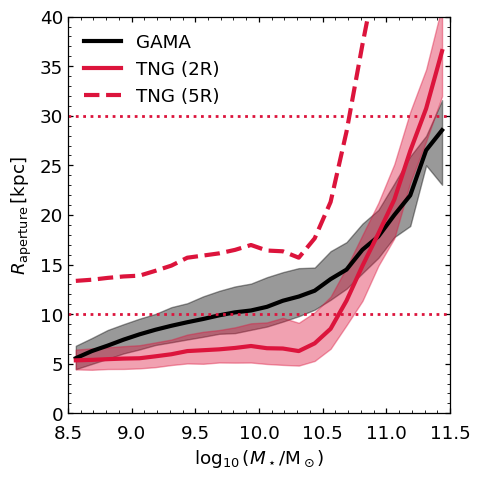

In [31]:
# Plot the median apertures in bins of stellar mass, compare to TNG100 aperture of two/five stellar half-mass radii

logmstarBins = np.linspace(8.5, 11.5, 25)
logmstarBinMidpoints = (logmstarBins[:-1] + logmstarBins[1:]) / 2.

colorList = ['black', 'crimson', 'crimson']
labelList = ['GAMA', 'TNG (2R)', 'TNG (5R)']
linestyleList = ['-', '-', '--']



fig = plt.figure(figsize = (5., 5.))
ax = fig.add_subplot(111)

for idxDataset in range(3):
    if idxDataset == 0: # GAMA aperture
        aperture = aperture_GAMA
        logmstar = np.log10(Mstar_GAMA)
    elif idxDataset == 1: # TNG aperture (2 stellar half-mass radii)
        aperture = 2. * np.concatenate((Rstar_TNG['TNG100_1_99'], Rstar_TNG['TNG100_1_91']))
        logmstar = np.log10(np.concatenate((MstarInRad_TNG['TNG100_1_99'], MstarInRad_TNG['TNG100_1_91'])))
    else: # TNG aperture (5 stellar half-mass radii)
        aperture = 5. * np.concatenate((Rstar_TNG['TNG100_1_99'], Rstar_TNG['TNG100_1_91']))
        logmstar = np.log10(np.concatenate((MstarInRad_TNG['TNG100_1_99'], MstarInRad_TNG['TNG100_1_91'])))

    lower = []
    median = []
    upper = []

    for idx in range(len(logmstarBins) - 1): # Compute the running median and interquartile range
        SEL_logmstar = (logmstar >= logmstarBins[idx]) * (logmstar < logmstarBins[idx + 1])
        lower.append(np.percentile(aperture[SEL_logmstar], 25.))
        median.append(np.median(aperture[SEL_logmstar]))
        upper.append(np.percentile(aperture[SEL_logmstar], 75.))

    ax.plot(logmstarBinMidpoints, median, color = colorList[idxDataset], linewidth = 3.,
            label = labelList[idxDataset], linestyle = linestyleList[idxDataset])
    if idxDataset <= 1:
        ax.fill_between(logmstarBinMidpoints, lower, upper, color = colorList[idxDataset], alpha = 0.4)

ax.set_xlabel(r'$\log_{10}(M_\star/\mathrm{M}_\odot)$')
ax.set_ylabel(r'$R_\mathrm{aperture}\,[\mathrm{kpc}]$')

lg = ax.legend(loc = 'upper left')
lg.get_frame().set_linewidth(0.0)
lg.get_frame().set_alpha(None)

ax.tick_params(which='both', direction='in', top=True, right=True)
ax.tick_params(axis='x', which='both', pad=8.)
ax.minorticks_on()

ax.axhline(10., color = 'crimson', linewidth = 2., linestyle = 'dotted')
ax.axhline(30., color = 'crimson', linewidth = 2., linestyle = 'dotted')

ax.set_xlim(8.5, 11.5)
ax.set_ylim(0., 40.)

plt.tight_layout()
plt.show()


This figure motivates the choice of two stellar half-mass radii as TNG100 aperture when comparing to GAMA LAMBDAR fluxes.

## Redshifting TNG fluxes

The TNG fluxes are available in the rest-frame or the observer-frame at the snapshot redshift. On the other hand, the GAMA fluxes are measured in the observer-frame over the continuous redshift range of the sample. To mimic this effect, we compute observer-frame TNG fluxes at arbitrary redshifts, by redshifting the TNG SEDs from the snapshot redshift to an arbitrary other redshift. The rest of the notebook is performed for either TNG100-1 or TNG50-1, as chosen in the cell below.

In [32]:
simForAnalysis = 'TNG100_1' # Default: TNG100_1. Can also choose TNG50_1.

In [33]:
def MagAtRedshift(snapshot, band, z, aperture = 2, orientation = 2): # Default aperture of two stellar half-mass radii and random orientation

    z_snap = TNG_redshifts[snapshot]

    SED_at_z_snap = SEDs_SKIRT[simForAnalysis + '_' + snapshot][:, :, aperture, orientation] # Flux in Jy
    
    filterFile = np.loadtxt('SVOfilters/' + band + '.dat')
    w = filterFile[:, 0] * 1e-4 # From Angstrom to micron
    T = filterFile[:, 1] 
    if ('GALEX' in band) or ('SDSS' in band) or ('VISTA' in band): # GALEX, SDSS and VISTA bands are photon counters
        T *= w # Multiply with wavelength if instrument is photon counter
    filterFunction = interpolate.interp1d(w, T, bounds_error = False, fill_value = 0.)

    factor = (1. + z) / (1. + z_snap)

    F = np.sum(filterFunction(SEDwavelengths_SKIRT[None, :] * factor[:, None]) * SED_at_z_snap * factor[:, None], axis = 1) / np.sum(filterFunction(SEDwavelengths_SKIRT[None, :] * factor[:, None]), axis = 1)

    # Now, convert to absolute magnitudes

    if snapshot == '99':
        dist  = 20e6 # pc
    else:
        dist = cosmo.luminosity_distance(z_snap).value * 1e6

    with np.errstate(divide = 'ignore'):
        M_AB = -2.5 * np.log10(F / 3631.) - 5. * np.log10(dist / 10.)

    m_AB = M_AB + 5. * np.log10(cosmo.luminosity_distance(z).value * 1e5)
    
    # Return absolute and apparent magnitudes
    return M_AB, m_AB


Define a function to compute random redshifts.

In [34]:
def drawRandomRedshift(Ngal, zmin, zmax):
    V_tot = 4. * np.pi / 3. * (cosmo.comoving_distance(zmax).value**3 - cosmo.comoving_distance(zmin).value**3) # Survey volume, In Mpc^3

    t = np.random.random(Ngal)

    D = (3. * V_tot * t / (4. * np.pi) + cosmo.comoving_distance(zmin).value**3)**(1. / 3.) # In Mpc

    # Convert random comoving distance to redshift. This could be done more accurately with astropy but this way is much faster,
    # and the loss of accuracy is negligible.

    zGrid = np.linspace(zmin, zmax, 1000)
    DGrid = cosmo.comoving_distance(zGrid).value

    interpolator = interpolate.interp1d(DGrid, zGrid)

    z = interpolator(D)

    return z



Compute random redshifts.

In [35]:
zRandom = {}

for snap in ['99', '91']:
    groupIDs = GrNr_TNG[simForAnalysis + '_' + snap]
    zRandomHalo = drawRandomRedshift(len(np.unique(groupIDs)), 0.002, 0.1) # Compute random redshifts between 0.002 and 0.1
    zRandomSubhalo = []

    idx = 0
    for groupID in groupIDs:
        if groupID != np.unique(groupIDs)[idx]:
            idx += 1
        zRandomSubhalo.append(zRandomHalo[idx])
            
    zRandom[snap] = np.array(zRandomSubhalo)



Compute flux threshold values based on the GAMA data. These flux threshold values act as a first-order completeness estimate, and are applied equally to both the GAMA and TNG fluxes to discard faint galaxies for the following results.

In [36]:
SNRcut = 3 # Minimum signal-to-noise for the GAMA data
fluxThresholdPercentile = 10. # Minimum flux threshold (expressed as a percentile in percent)

fluxThresholds = {}

# Loop over all bands

GAMAbands = list(pivotWavelengthsGAMA.keys())

for band in GAMAbands:

    F = F_GAMA[band]
    Ferror = Ferror_GAMA[band]

    SEL_reliable = (F / Ferror >= SNRcut) * (F > 0.) # Select only reliable measurements

    F_reliable = F[SEL_reliable]

    threshold = np.percentile(F_reliable, fluxThresholdPercentile) # Compute the flux threshold
    print('The flux threshold for band', band, 'is:', np.round(threshold, 8), 'Jy')
    fluxThresholds[band] = threshold

The flux threshold for band GALEX_FUV is: 4.48e-06 Jy
The flux threshold for band GALEX_NUV is: 6.36e-06 Jy
The flux threshold for band SDSS_u is: 1.412e-05 Jy
The flux threshold for band SDSS_g is: 3.79e-05 Jy
The flux threshold for band SDSS_r is: 5.757e-05 Jy
The flux threshold for band SDSS_i is: 7.441e-05 Jy
The flux threshold for band SDSS_z is: 8.212e-05 Jy
The flux threshold for band VISTA_Z is: 8.248e-05 Jy
The flux threshold for band VISTA_Y is: 9.367e-05 Jy
The flux threshold for band VISTA_J is: 9.424e-05 Jy
The flux threshold for band VISTA_H is: 0.00010915 Jy
The flux threshold for band VISTA_K is: 0.0001003 Jy
The flux threshold for band WISE_W1 is: 0.00012574 Jy
The flux threshold for band WISE_W2 is: 0.00018092 Jy
The flux threshold for band WISE_W3 is: 0.00040238 Jy
The flux threshold for band WISE_W4 is: 0.00424885 Jy
The flux threshold for band PACS_100 is: 0.05391827 Jy
The flux threshold for band PACS_160 is: 0.06575854 Jy
The flux threshold for band SPIRE_250 is:

Define a function to compute a 1D weighted KS-test.

In [37]:
def computeKStest1D(data1, data2, weights1, weights2):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    weights1 = weights1[ix1]
    weights2 = weights2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(weights1)/sum(weights1)])
    cwei2 = np.hstack([0, np.cumsum(weights2)/sum(weights2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]
    return np.max(np.abs(cdf1we - cdf2we))

Lastly, define a little helper script to compute a kernel density estimate.

In [38]:
def computeKDE(xData, yData, x_KDE, y_KDE, percentileLevels, weights = None): # Helper function to compute 2D kernel density estimate
    values = np.vstack([xData, yData])
    kernel = stats.gaussian_kde(values, weights = weights)
    positions = np.vstack([x_KDE.ravel(), y_KDE.ravel()])
    KDE = np.reshape(kernel(positions).T, x_KDE.shape) # 2d array with kde estimate


    percentiles = np.cumsum(np.sort(KDE, axis = None)) / np.sum(KDE) # 1d array of the sorted cumulative sum of the kde estimate (normalized to 1)
    argPercentiles = []

    for number in percentileLevels: # The percentile levels
        argPercentiles.append(np.argmax(percentiles[percentiles <= number]))

    argPercentiles = np.array(argPercentiles)

    levels = np.sort(KDE, axis = None)[argPercentiles] # The 0.3 level now effectively corresponds to an area enclosing the densest 70% of the galaxy sample

    return KDE, levels

## Relations between fluxes

Compare the TNG broadband fluxes to low-redshift GAMA data by exploring flux-flux plots (figures 4, A1, and B1). Always use the UKIDSS K flux on the x-axis as this is a tracer for stellar mass.

In [39]:
# Define the plotting settings

bands_plot = ['GALEX_FUV', 'SDSS_r', 'WISE_W1', 'WISE_W3', 'PACS_100', 'SPIRE_500']

yLabels = [r'$\log_{10}(L_\mathrm{FUV}/\mathrm{L}_\odot)$', r'$\log_{10}(L_r/\mathrm{L}_\odot)$', r'$\log_{10}(L_\mathrm{W1}/\mathrm{L}_\odot)$',
           r'$\log_{10}(L_\mathrm{W3}/\mathrm{L}_\odot)$', r'$\log_{10}(L_\mathrm{P100}/\mathrm{L}_\odot)$', r'$\log_{10}(L_\mathrm{S500}/\mathrm{L}_\odot)$']


Define the plotting function.

In [40]:
def plotFluxes(apertureIdx = 2, conditionalKDE = False):
    # Default aperture set to two stellar half-mass radii, and conditional KDE is off

    Nbins = 50 # Number of bins for the 1D histograms
    KDEresolution = 100j # Number of bins for the 2D KDE (must be a complex number!)
    percentileLevels = [0.05, 0.25, 0.6, 0.9] # Levels for the 2D KDE
    cmapValues = [0.3, 0.5, 0.7, 0.9] # Change these numbers to adjust contour colors

    percentileBorder = 0.3 # Plot covers range from and up to the most extreme values, given as percentiles (in percent)

    cmap_TNG = matplotlib.colormaps['OrRd']
    cmap_GAMA = matplotlib.colormaps['Greys']

    # Compute the TNG magnitudes at arbitrary redshifts

    M_AB_redshifted_TNG = {}
    m_AB_redshifted_TNG = {}

    for band in np.append(bands_plot, 'VISTA_K'):
        M_AB_redshifted_singleBand = []
        m_AB_redshifted_singleBand = []
        for snap in ['99', '91']:
            M_AB_temp, m_AB_temp = MagAtRedshift(snap, band, zRandom[snap], aperture = apertureIdx)
            M_AB_redshifted_singleBand.append(M_AB_temp)
            m_AB_redshifted_singleBand.append(m_AB_temp)
        
        M_AB_redshifted_TNG[band] = np.concatenate((M_AB_redshifted_singleBand))
        m_AB_redshifted_TNG[band] = np.concatenate((m_AB_redshifted_singleBand))


    fig = plt.figure(figsize = (12., 16.))

    for idx_i in range(3):
        for idx_j in range(2):
            idx = 2 * idx_i + idx_j
            
            band = bands_plot[idx]


            # Create the figure and axes

            gs = fig.add_gridspec(2, 2,  width_ratios = (3, 1), height_ratios = (1, 3), left = 0.1 + 0.48 * idx_j, right = 0.5 + 0.48 * idx_j, bottom = 0.71 - 0.33 * idx_i, top = 0.99 - 0.33 * idx_i ,
                                wspace = 0., hspace = 0.)

            ax_main = fig.add_subplot(gs[1, 0])
            ax_histx = fig.add_subplot(gs[0, 0], sharex = ax_main)
            ax_histy = fig.add_subplot(gs[1, 1], sharey = ax_main)


            # Compute the TNG distributions



            SEL_TNG = np.full(len(np.concatenate((IDs_SKIRT[simForAnalysis + '_99'], IDs_SKIRT[simForAnalysis + '_91']))), True)

            F_TNG = 10**(m_AB_redshifted_TNG['VISTA_K'] * -0.4) * 3631. # Convert to Flux in Jy
            SEL_TNG *= (F_TNG >= fluxThresholds['VISTA_K']) # Select only TNG galaxies that have a large enough K-band flux
            F_TNG = 10**(m_AB_redshifted_TNG[band] * -0.4) * 3631. # Convert to Flux in Jy
            SEL_TNG *= (F_TNG >= fluxThresholds[band]) # Select only TNG galaxies that have a large enough flux in the respective band

            N_TNG = len(SEL_TNG[SEL_TNG])

            with np.errstate(invalid = 'ignore', divide = 'ignore'):

                x_TNG = np.log10(Mab_to_L(M_AB_redshifted_TNG['VISTA_K'], pivotWavelengthsGAMA['VISTA_K']))[SEL_TNG] # Luminosity (in solar luminosity)

                y_TNG = np.log10(Mab_to_L(M_AB_redshifted_TNG[band], pivotWavelengthsGAMA[band]))[SEL_TNG] # Luminosity (in solar luminosity)

            # Compute the GAMA distributions
            
            SEL_GAMA = np.full(len(Mstar_GAMA), True)

            F = F_GAMA['VISTA_K']
            Ferror = Ferror_GAMA['VISTA_K']
            SEL_GAMA *= (F / Ferror >= 3.) * (F >= fluxThresholds['VISTA_K'])

            F = F_GAMA[band]
            Ferror = Ferror_GAMA[band]
            SEL_GAMA *= (F / Ferror >= 3.) * (F >= fluxThresholds[band])
            
            N_GAMA = len(SEL_GAMA[SEL_GAMA])

            Mag_GAMA = -2.5 * np.log10(F_GAMA['VISTA_K'][SEL_GAMA] / 3631.) - 5. * np.log10(cosmo.luminosity_distance(z_GAMA[SEL_GAMA]).value * 1e6 / 10.)
            x_GAMA = np.log10(Mab_to_L(Mag_GAMA, pivotWavelengthsGAMA['VISTA_K'])) # Luminosity (in solar luminosity)
            xerror_GAMA = 1. / (F_GAMA['VISTA_K'][SEL_GAMA] * np.log(10.)) * Ferror_GAMA['VISTA_K'][SEL_GAMA]

            Mag_GAMA = -2.5 * np.log10(F_GAMA[band][SEL_GAMA] / 3631.) - 5. * np.log10(cosmo.luminosity_distance(z_GAMA[SEL_GAMA]).value * 1e6 / 10.)
            y_GAMA = np.log10(Mab_to_L(Mag_GAMA, pivotWavelengthsGAMA[band])) # Luminosity (in solar luminosity)
            yerror_GAMA = 1. / (F_GAMA[band][SEL_GAMA] * np.log(10.)) * Ferror_GAMA[band][SEL_GAMA]


            # Compute the bins

            min_x = min(np.percentile(x_TNG, percentileBorder), np.percentile(x_GAMA, percentileBorder))
            max_x = max(np.percentile(x_TNG, 100. - percentileBorder), np.percentile(x_GAMA, 100. - percentileBorder))
            min_y = min(np.percentile(y_TNG, percentileBorder), np.percentile(y_GAMA, percentileBorder))
            max_y = max(np.percentile(y_TNG, 100. - percentileBorder), np.percentile(y_GAMA, 100. - percentileBorder))

            bins_x = np.linspace(min_x, max_x, Nbins)
            bins_y = np.linspace(min_y, max_y, Nbins)

            x_KDE, y_KDE = np.mgrid[min_x:max_x:KDEresolution, min_y:max_y:KDEresolution]

            # Compute weights for the GAMA galaxies if we force them to follow the TNG PDF along the x-axis

            if conditionalKDE:
                with np.errstate(divide = 'ignore', invalid = 'ignore'):
                    histogramRatio = np.histogram(x_TNG, bins = bins_x, density = True)[0] / np.histogram(x_GAMA, bins = bins_x, density = True)[0]
                indicesHistogram = np.clip(np.digitize(np.clip(x_GAMA, min_x, max_x), bins_x, right = True) - 1, a_min = 0, a_max = None)
                
                weightsGAMA = histogramRatio[indicesHistogram]
                weightsGAMA[np.isnan(weightsGAMA) + np.isinf(weightsGAMA)] = 0. # If there's no GAMA or TNG galaxies in a specific x-axis bin, set the weight to 0

                D_KS = computeKStest1D(y_TNG, y_GAMA, np.ones_like(y_TNG), weightsGAMA) # 1D weighted KS-test

            else:
                weightsGAMA = np.ones_like(x_GAMA)
                if import_ndtest:
                    D_KS = ndtest.ks2d2s(x_TNG, y_TNG, x_GAMA, y_GAMA, extra = True)[1] # 2D KS-test
                else:
                    D_KS = -999.
            # Plot the KDEs and histograms

            KDE_TNG, KDElevels_TNG = computeKDE(x_TNG, y_TNG, x_KDE, y_KDE, percentileLevels)

            ax_main.contour(x_KDE, y_KDE, KDE_TNG, levels = KDElevels_TNG, colors = [cmap_TNG(i) for i in cmapValues], linewidths = 3., zorder = 10)


            ax_histx.hist(x_TNG, bins_x, density = True, histtype = 'step', color = 'crimson', linewidth = 2., zorder = 10, label = 'TNG')
            ax_histy.hist(y_TNG, bins_y, density = True, histtype = 'step', color = 'crimson', linewidth = 2., orientation = 'horizontal', zorder = 10)
                
            KDE_GAMA, KDElevels_GAMA = computeKDE(x_GAMA, y_GAMA, x_KDE, y_KDE, percentileLevels, weights = weightsGAMA)

            ax_main.contour(x_KDE, y_KDE, KDE_GAMA, levels = KDElevels_GAMA, colors = [cmap_GAMA(i) for i in cmapValues], linewidths = 3.)


            ax_histx.hist(x_GAMA, bins_x, density = True, weights = weightsGAMA, histtype = 'step', color = 'black', linewidth = 2., label = 'GAMA')
            ax_histy.hist(y_GAMA, bins_y, density = True, weights = weightsGAMA, histtype = 'step', color = 'black', linewidth = 2., orientation = 'horizontal')


            # Plot the GAMA errors

            ellipseMedian = matplotlib.patches.Ellipse(xy = ax_main.transLimits.inverted().transform((0.1, 0.85)),
                                                    width = 2. * np.median(xerror_GAMA), height = 2. * np.median(yerror_GAMA), color = 'black')
            ax_main.add_patch(ellipseMedian)
            ellipseUpper = matplotlib.patches.Ellipse(xy = ax_main.transLimits.inverted().transform((0.1, 0.85)),
                                                    width = 2. * np.percentile(xerror_GAMA, 75.), height = 2. * np.percentile(yerror_GAMA, 75.), color = 'grey', alpha = 0.5)
            ax_main.add_patch(ellipseUpper)



            # Finalize axis settings
            ax_main.text(x = 1.01, y = 1.24, s = r'$N_\mathrm{TNG}=$' + str(N_TNG), color = 'crimson', transform = ax_main.transAxes)
            ax_main.text(x = 1.01, y = 1.14, s = r'$N_\mathrm{GAMA}=$' + str(N_GAMA), color = 'black', transform = ax_main.transAxes)

            ax_main.text(x = 1.01, y = 1.04, s = r'$D_\mathrm{KS}=$' + str(np.round(D_KS, 2)), color = 'black', transform = ax_main.transAxes)

            ax_main.set_xlabel(r'$\log_{10}(L_\mathrm{K}/\mathrm{L}_\odot)$')
            ax_main.set_ylabel(yLabels[idx])

            if idx == 0:
                lg = ax_histx.legend(loc = 'upper right')
                lg.get_frame().set_linewidth(0.0)
                lg.get_frame().set_alpha(0.)

            ax_histx.set_ylabel(r'$\mathrm{PDF}\,[\mathrm{dex}^{-1}]$')
            ax_histy.set_xlabel(r'$\mathrm{PDF}\,[\mathrm{dex}^{-1}]$')


            for ax in [ax_main, ax_histx, ax_histy]:
                ax.tick_params(which='both', direction='in', top=True, right=True)
                ax.minorticks_on()

            ax_histx.tick_params(axis="x", labelbottom=False)
            ax_histy.tick_params(axis="y", labelleft=False)
    plt.show()

Create the main flux-flux plot (figures 4 for TNG100 and A1 for TNG50).

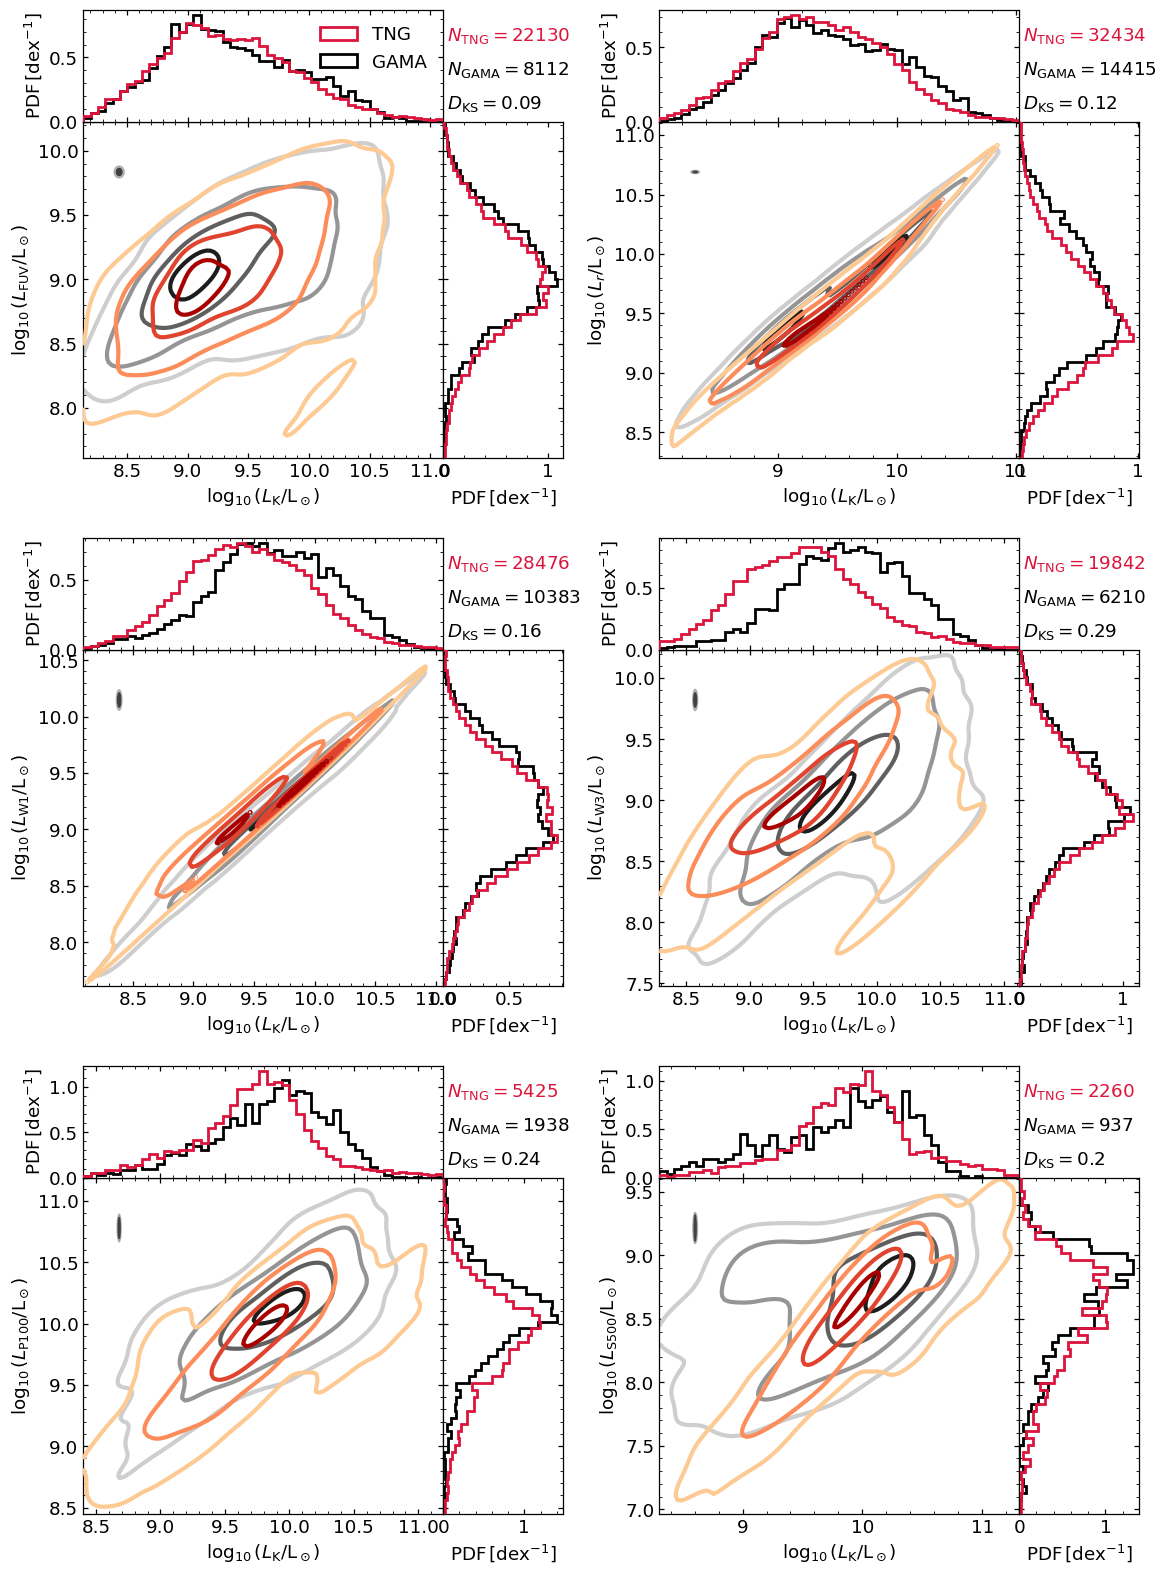

In [41]:
plotFluxes()

Make the same plot again, but using a conditional KDE (figure B1). This means that we effectively match the GAMA and TNG K-band luminosity distributions.

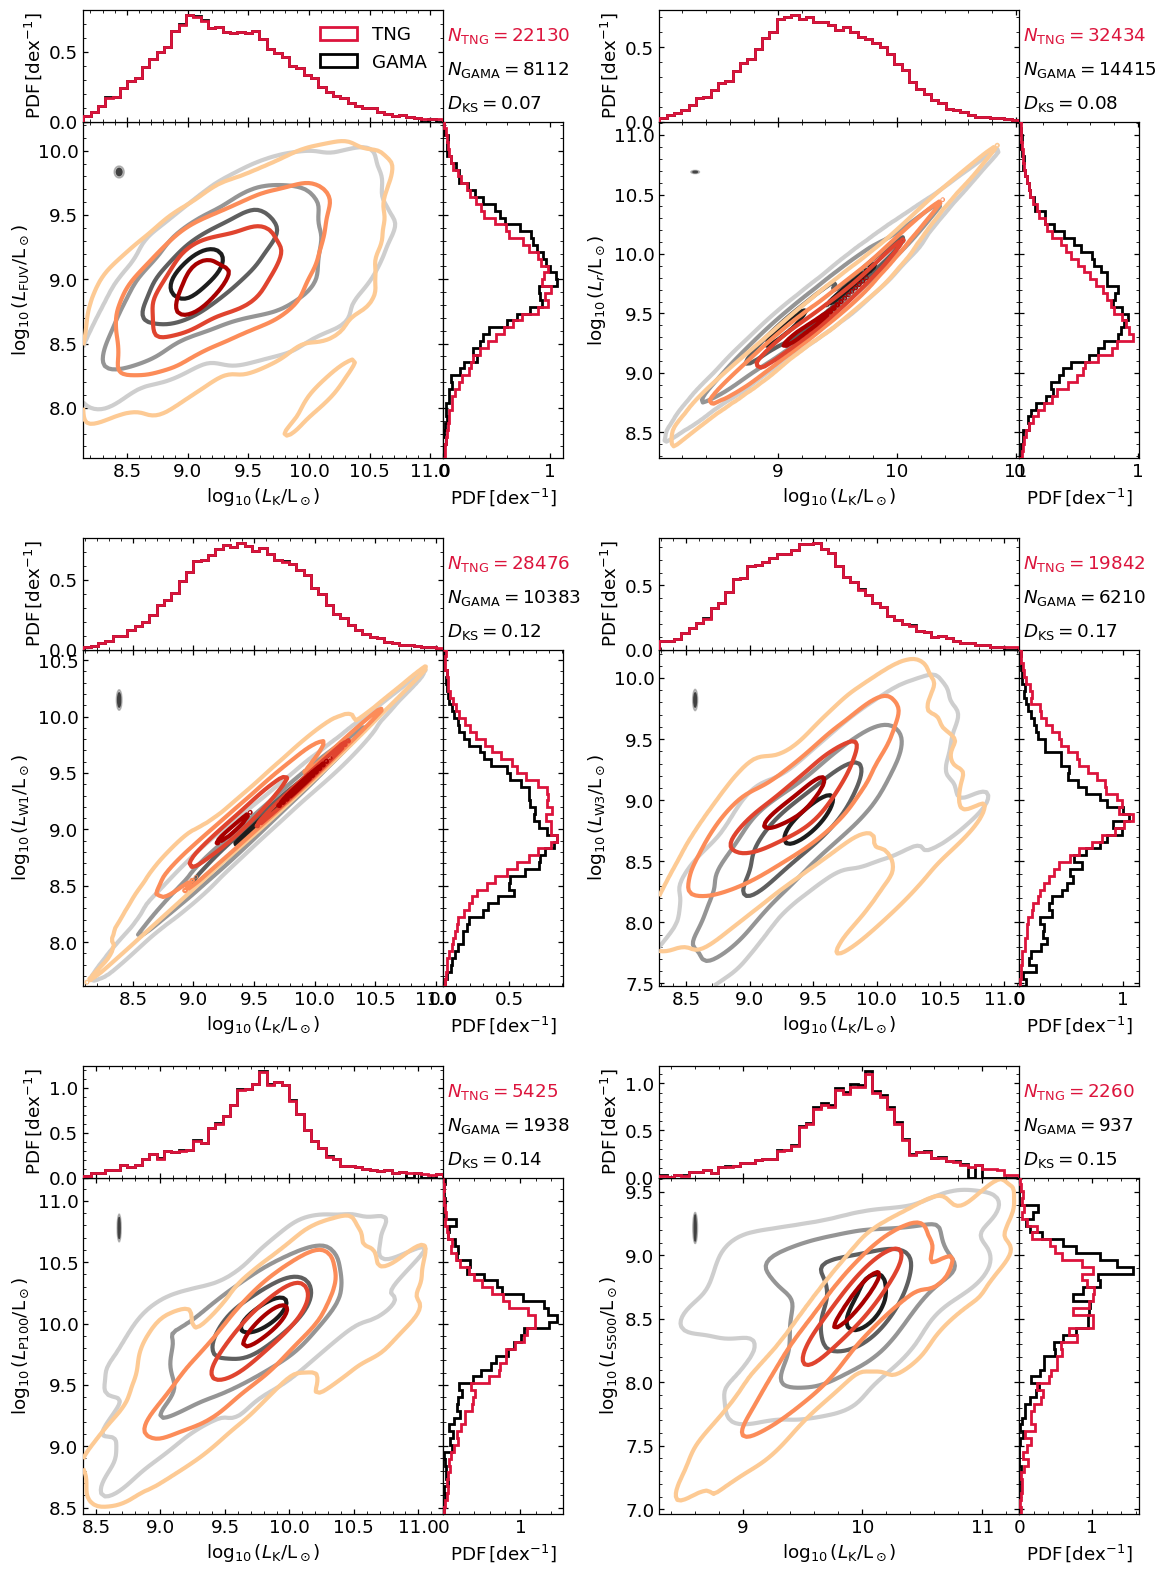

In [42]:
plotFluxes(conditionalKDE = True)

## Relations between colors

Compare the TNG broadband fluxes to low-redshift GAMA data by exploring color-color relations (figures 5 for TNG100 and A2 for TNG50).

In [43]:
# Define the plotting settings

bands_plot = {'0': {'x': ['SDSS_r', 'VISTA_J'], 'y': ['SDSS_u', 'SDSS_r']},
            '1': {'x': ['GALEX_FUV', 'VISTA_K'], 'y': ['VISTA_K', 'SPIRE_250']},
            '2': {'x': ['GALEX_FUV', 'VISTA_K'], 'y': ['GALEX_FUV', 'GALEX_NUV']},
            '3': {'x': ['WISE_W4', 'SPIRE_250'], 'y': ['WISE_W3', 'SPIRE_250']}}


xLabels = ['SDSS r - VISTA J [mag]', 'GALEX FUV - VISTA K [mag]', 'GALEX FUV - VISTA K [mag]', 'WISE W4 - SPIRE 250 [mag]']
yLabels = ['SDSS u - SDSS r [mag]', 'VISTA K - SPIRE 250 [mag]',  'GALEX FUV - GALEX NUV [mag]', 'WISE W3 - SPIRE 250 [mag]']


Define the color-color plotting function.

In [44]:
def plotColors(apertureIdx = 2):
    # Use a default aperture of two stellar half-mass radii
    # Define the plotting settings for the color-color plot

    Nbins = 50 # Number of bins for the 1D histograms
    KDEresolution = 100j # Number of bins for the 2D KDE (must be a complex number!)
    percentileLevels = [0.05, 0.25, 0.6, 0.9] # Levels for the 2D KDE
    cmapValues = [0.3, 0.5, 0.7, 0.9] # Change these numbers to adjust contour colors
    percentileBorder = 0.1 # Plot covers range from and up to the most extreme values, given as percentiles (in percent)

    cmap_TNG = matplotlib.colormaps['OrRd']
    cmap_GAMA = matplotlib.colormaps['Greys']

    # Compute the TNG magnitudes at arbitrary redshifts

    M_AB_redshifted_TNG = {}
    m_AB_redshifted_TNG = {}

    for band in pivotWavelengthsGAMA.keys():
        M_AB_redshifted_singleBand = []
        m_AB_redshifted_singleBand = []
        for snap in ['99', '91']:
            M_AB_temp, m_AB_temp = MagAtRedshift(snap, band, zRandom[snap], aperture = apertureIdx)
            M_AB_redshifted_singleBand.append(M_AB_temp)
            m_AB_redshifted_singleBand.append(m_AB_temp)
        
        M_AB_redshifted_TNG[band] = np.concatenate((M_AB_redshifted_singleBand))
        m_AB_redshifted_TNG[band] = np.concatenate((m_AB_redshifted_singleBand))


    fig = plt.figure(figsize = (12., 12.))

    for idx_i in range(2):
        for idx_j in range(2):
            idx = 2 * idx_i + idx_j

            # Create the figure and axes

            gs = fig.add_gridspec(2, 2,  width_ratios = (3, 1), height_ratios = (1, 3), left = 0.1 + 0.48 * idx_j, right = 0.5 + 0.48 * idx_j, bottom = 0.55 - 0.5 * idx_i, top = 0.98 - 0.5 * idx_i ,
                                wspace = 0., hspace = 0.)

            ax_main = fig.add_subplot(gs[1, 0])
            ax_histx = fig.add_subplot(gs[0, 0], sharex = ax_main)
            ax_histy = fig.add_subplot(gs[1, 1], sharey = ax_main)


            # Compute the TNG distributions
            SEL_TNG = np.full(len(np.concatenate((IDs_SKIRT[simForAnalysis + '_99'], IDs_SKIRT[simForAnalysis + '_91']))), True)

            for band in bands_plot[str(idx)]['x']:
                F_TNG = 10**(m_AB_redshifted_TNG[band] * -0.4) * 3631. # Convert to Flux in Jy
                SEL_TNG *= (F_TNG >= fluxThresholds[band])
            for band in bands_plot[str(idx)]['y']:
                F_TNG = 10**(m_AB_redshifted_TNG[band] * -0.4) * 3631. # Convert to Flux in Jy
                SEL_TNG *= (F_TNG >= fluxThresholds[band])

            N_TNG = len(SEL_TNG[SEL_TNG])


            x_TNG = (M_AB_redshifted_TNG[bands_plot[str(idx)]['x'][0]] - M_AB_redshifted_TNG[bands_plot[str(idx)]['x'][1]])[SEL_TNG] # Color (in magnitudes)

            y_TNG = (M_AB_redshifted_TNG[bands_plot[str(idx)]['y'][0]] - M_AB_redshifted_TNG[bands_plot[str(idx)]['y'][1]])[SEL_TNG] # Color (in magnitudes)


            # Compute the GAMA distributions
        
            SEL_GAMA = np.full(len(Mstar_GAMA), True)

            for band in bands_plot[str(idx)]['x']:
                F = F_GAMA[band]
                Ferror = Ferror_GAMA[band]
                SEL_GAMA *= (F / Ferror >= 3.) * (F >= fluxThresholds[band])
            for band in bands_plot[str(idx)]['y']:
                F = F_GAMA[band]
                Ferror = Ferror_GAMA[band]
                SEL_GAMA *= (F / Ferror >= 3.) * (F >= fluxThresholds[band])

            N_GAMA = len(SEL_GAMA[SEL_GAMA])
            

            x_GAMA = -2.5 * np.log10(F_GAMA[bands_plot[str(idx)]['x'][0]][SEL_GAMA] / F_GAMA[bands_plot[str(idx)]['x'][1]][SEL_GAMA]) # Color (in magnitudes)
            xerror_GAMA = np.sqrt((2.5 / (F_GAMA[bands_plot[str(idx)]['x'][0]][SEL_GAMA] * np.log(10.)) * Ferror_GAMA[bands_plot[str(idx)]['x'][0]][SEL_GAMA])**2 +\
                                    (2.5 / (F_GAMA[bands_plot[str(idx)]['x'][1]][SEL_GAMA] * np.log(10.)) * Ferror_GAMA[bands_plot[str(idx)]['x'][1]][SEL_GAMA])**2)

            y_GAMA = -2.5 * np.log10(F_GAMA[bands_plot[str(idx)]['y'][0]][SEL_GAMA] / F_GAMA[bands_plot[str(idx)]['y'][1]][SEL_GAMA]) # Color (in magnitudes)
            yerror_GAMA = np.sqrt((2.5 / (F_GAMA[bands_plot[str(idx)]['y'][0]][SEL_GAMA] * np.log(10.)) * Ferror_GAMA[bands_plot[str(idx)]['y'][0]][SEL_GAMA])**2 +\
                                    (2.5 / (F_GAMA[bands_plot[str(idx)]['y'][1]][SEL_GAMA] * np.log(10.)) * Ferror_GAMA[bands_plot[str(idx)]['y'][1]][SEL_GAMA])**2)
                
            if import_ndtest:
                D_KS = ndtest.ks2d2s(x_TNG, y_TNG, x_GAMA, y_GAMA, extra = True)[1] # 2D KS-test
            else:
                D_KS = -999.

            # Compute the bins

            min_x = min(np.percentile(x_TNG, percentileBorder), np.percentile(x_GAMA, percentileBorder))
            max_x = max(np.percentile(x_TNG, 100. - percentileBorder), np.percentile(x_GAMA, 100. - percentileBorder))
            min_y = min(np.percentile(y_TNG, percentileBorder), np.percentile(y_GAMA, percentileBorder))
            max_y = max(np.percentile(y_TNG, 100. - percentileBorder), np.percentile(y_GAMA, 100. - percentileBorder))


            bins_x = np.linspace(min_x, max_x, Nbins)
            bins_y = np.linspace(min_y, max_y, Nbins)

            x_KDE, y_KDE = np.mgrid[min_x:max_x:KDEresolution, min_y:max_y:KDEresolution]
            
            # Plot the KDEs and histograms

            KDE_TNG, KDElevels_TNG = computeKDE(x_TNG, y_TNG, x_KDE, y_KDE, percentileLevels)

            ax_main.contour(x_KDE, y_KDE, KDE_TNG, levels = KDElevels_TNG, colors = [cmap_TNG(i) for i in cmapValues], linewidths = 3., zorder = 10)

            ax_histx.hist(x_TNG, bins_x, density = True, histtype = 'step', color = 'crimson', linewidth = 2., zorder = 10, label = 'TNG')
            ax_histy.hist(y_TNG, bins_y, density = True, histtype = 'step', color = 'crimson', linewidth = 2., orientation = 'horizontal', zorder = 10)
            
            KDE_GAMA, KDElevels_GAMA = computeKDE(x_GAMA, y_GAMA, x_KDE, y_KDE, percentileLevels)

            ax_main.contour(x_KDE, y_KDE, KDE_GAMA, levels = KDElevels_GAMA, colors = [cmap_GAMA(i) for i in cmapValues], linewidths = 3.)

            ax_histx.hist(x_GAMA, bins_x, density = True, histtype = 'step', color = 'black', linewidth = 2., label = 'GAMA')
            ax_histy.hist(y_GAMA, bins_y, density = True, histtype = 'step', color = 'black', linewidth = 2., orientation = 'horizontal')


            # Plot the GAMA errors

            if idx == 1:
                ellipse_y = 0.15
            else:
                ellipse_y = 0.85

            ellipseMedian = matplotlib.patches.Ellipse(xy = ax_main.transLimits.inverted().transform((0.12, ellipse_y)),
                                                    width = 2. * np.median(xerror_GAMA), height = 2. * np.median(yerror_GAMA), color = 'black')
            ax_main.add_patch(ellipseMedian)
            ellipseUpper = matplotlib.patches.Ellipse(xy = ax_main.transLimits.inverted().transform((0.12, ellipse_y)),
                                                    width = 2. * np.percentile(xerror_GAMA, 75.), height = 2. * np.percentile(yerror_GAMA, 75.), color = 'grey', alpha = 0.5)
            ax_main.add_patch(ellipseUpper)


            # Finalize axis settings
            ax_main.text(x = 1.01, y = 1.24, s = r'$N_\mathrm{TNG}=$' + str(N_TNG), color = 'crimson', transform = ax_main.transAxes)
            ax_main.text(x = 1.01, y = 1.14, s = r'$N_\mathrm{GAMA}=$' + str(N_GAMA), color = 'black', transform = ax_main.transAxes)

            ax_main.text(x = 1.01, y = 1.04, s = r'$D_\mathrm{KS}=$' + str(np.round(D_KS, 2)), color = 'black', transform = ax_main.transAxes)

            ax_main.set_xlabel(xLabels[idx])
            ax_main.set_ylabel(yLabels[idx])

            if idx == 1:
                lg = ax_histx.legend(loc = 'upper right')
                lg.get_frame().set_linewidth(0.0)
                lg.get_frame().set_alpha(0.)

            ax_histx.set_ylabel(r'$\mathrm{PDF}\,[\mathrm{mag}^{-1}]$')

            ax_histy.set_xlabel(r'$\mathrm{PDF}\,[\mathrm{mag}^{-1}]$')

            for ax in [ax_main, ax_histx, ax_histy]:
                ax.tick_params(which='both', direction='in', top=True, right=True)
                ax.minorticks_on()

            ax_histx.tick_params(axis="x", labelbottom=False)
            ax_histy.tick_params(axis="y", labelleft=False)
    plt.show()

Make the main color-color plot (figures 5 for TNG100 and A2 for TNG50).

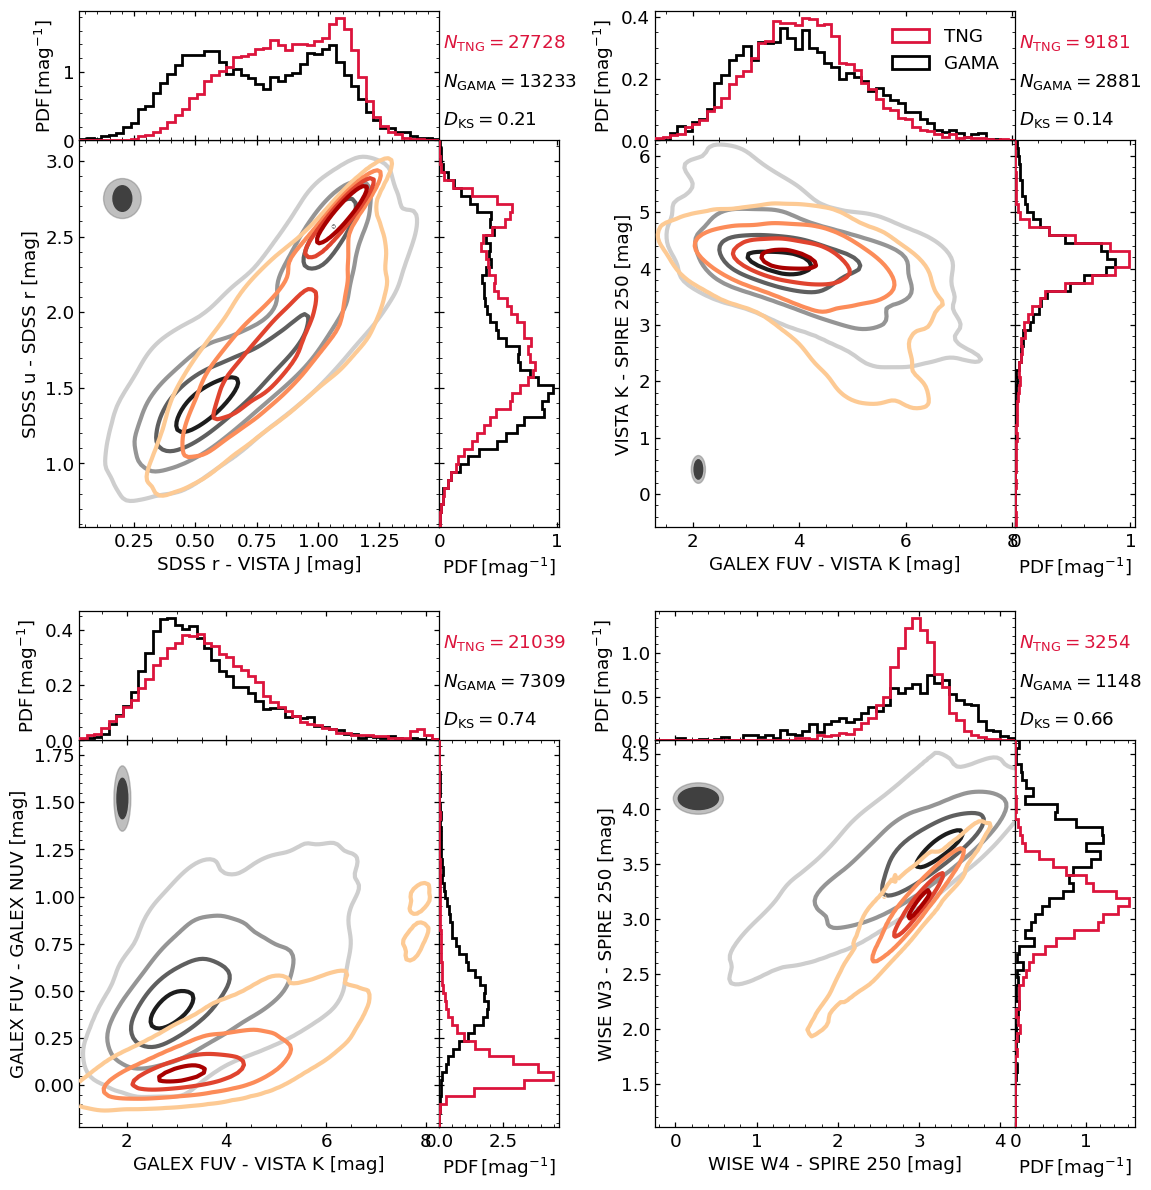

In [45]:
plotColors()